In [9]:
library(bnlearn)
library(Rgraphviz)
library(parallel)
library(tidyverse)
suppressWarnings(library(dplyr))
no_cores <- detectCores()-1
cl <- makeCluster(no_cores)
### dataset needs to be preprocessed because  for example had values as factors. My functions does not work w/factorslearning.test
library(tictoc)

Today i learnt that the k2 algorithm infers the dag, the directed acyclic graph, so the structure of the bayesian network from the dataset. Not from the fitted model. 
What i initially thought was that you happen to have a model and you want to reverse engineer that. 

In [ ]:
node.values <- function(dataset, parents) {
    # retrieves the unique values of the nodes
    #return a list of vectors, 
    # each vector contains the unique values of the corresponding node
    output <- list()
    for (kk in seq_along(parents)) {
        node <- parents[kk]
        node.vals <- unique(dataset[[node]]) #it was levels()
        output[[kk]] <- node.vals
    }
    return(output)
}

In [ ]:
old.alphaijk <- function(i, pii, dataset, nodes.order) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    output <- c()
    for (tracker in 1:dim(unique.instantiations)[1]){
        aa <- 0
        for (j in 1:dim(subset)[1]) {
            ifelse(all(as.vector(unlist(subset[j,])) == as.vector(unlist(unique.instantiations[tracker,]))), aa <- aa +1, FALSE)
        }
        output <- c(output,aa)
    }
    return(output)
}

In [ ]:
fastalphaijk <- function(i, pii, dataset, nodes.order) {
    actual_node <- nodes.order[i]
    all.nodes <- c(pii, actual_node)
    subset <- dataset[all.nodes]
    unique.instantiations <- expand.grid(node.values(dataset, all.nodes))
    colnames(unique.instantiations) <- colnames(subset)
    subset.counted <- subset |> group_by(across(everything())) |> summarise(n = n(), .groups="drop")
    checking <-  left_join(unique.instantiations, subset.counted, by=colnames(subset), na_matches="na")  |> arrange(across(-last_col()))
    checking[is.na(checking)]<- 0
    #print(checking)
    return(checking$n)
}

In [ ]:
k2helper <- function(i, pii, dataset, nodes.order) {
    # the "f" function in the pdf
    phi_i <- expand.grid(node.values(dataset, pii)) 
    #cat("\nphi.i")
    #print( phi_i)
    q_i <- dim(phi_i)[1] # works good
    #cat("\nqi.i", q_i)
    nodes <- colnames(dataset)
    #cat("\nnodes", nodes)
    i.th.node <- nodes[i]
    #cat("\nithnode", i.th.node)
    v_i <- node.values(dataset, i.th.node)
    #cat("\nvi")
    #print( c(v_i))
    r_i <- length(v_i[[1]])
    #cat("ri", r_i)
    individual_alphas <- fastalphaijk(i, pii, dataset, nodes.order) # works good
    #cat("\nindividual alphas::",individual_alphas)
    aijk <- prod(factorial(individual_alphas)) ##
    #numeratore <- factorial(r_i-1)
    grouping_alphas <- matrix(individual_alphas, nrow=r_i) # to get the right Nijs
    nij <- colSums(grouping_alphas)
    #print(nij)
    produttoria_alpha <- prod(factorial(individual_alphas))
    numeratore <- factorial(r_i-1)
    denominatore <- factorial(nij+r_i-1)
    out <- prod((numeratore/denominatore))*produttoria_alpha
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #cat("\nproduttoria_alpha",produttoria_alpha )
    #print(frazione)
    return(out)
}

In [19]:
k2 <- function(dataset, nodes.order, upperbound) {
    start <- Sys.time()

    edges <- list()  # ← new: store edges here
    
    nodes <- colnames(dataset)
    for (i in seq_along(nodes.order)) {
        actual_node <- nodes.order[i]
        #cat("\n", i,"\n")
        pii <- c()
        p.old <- k2helper(i, pii,dataset, nodes.order)
        #cat("\n ",p.old, "\n should be ", 1/2772)
        proceed <- TRUE
        cat("\ni::",i, "\n")
        while (proceed && length(pii) < upperbound) {
            predecessors_idx <- i-1
            predecessors <- nodes.order[0:predecessors_idx]
            cat("\npredecessors::", predecessors, " pii:: ", pii)
            piiuz <- setdiff(predecessors, pii)
            if (length(piiuz) > 1) {
                daddy.s.probs <- c()
                for (daddy in seq_along(piiuz)) {
                    p.new <- k2helper(i, piiuz[daddy], dataset, nodes.order)
                    daddy.s.probs <- c(daddy.s.probs, p.new)
                }
                p.new <- max(daddy.s.probs)
                genitore <-  piiuz[daddy.s.probs == p.new]
            } else {
                p.new <- k2helper(i, piiuz, dataset, nodes.order)
                genitore <- piiuz
            }
            cat("\npiiuz:: ",piiuz,"\np.old:: ", p.old, "\np.new:: ", p.new)
            #roof <- roof+1
            if (p.new > p.old) {
                p.old <- p.new
                pii <- c(pii, genitore)
                #ifelse(roof>length(nodes)^length(nodes), proceed <- FALSE, proceed <- TRUE)
            } else  {
                proceed <- FALSE
            }
        }
        cat('\nNode', nodes.order[i], '--> Parents:', pii,'\n') 

        # Store edges: each pii is a parent of actual_node
        if (length(pii) > 0) {
            for (parent in pii) {
                edges[[length(edges) + 1]] <- c(parent, actual_node)
            }
        }
    }

    end <- Sys.time()
    execution_time <- difftime(time1 = end, time2 = start, units = "secs") 
    cat("\nExecution Time:", execution_time, "s")

    # Convert to matrix or return edge list
    edge_matrix <- do.call(rbind, edges)
    return(edge_matrix)
    
    #return(TRUE)
}


i:: 1 

predecessors::   pii:: 
piiuz::   
p.old::  0.0003607504 
p.new::  0.0003607504
Node x1 --> Parents: 

i:: 2 

predecessors:: x1  pii:: 
piiuz::  x1 
p.old::  0.0003607504 
p.new::  0.001111111
predecessors:: x1  pii::  x1
piiuz::   
p.old::  0.001111111 
p.new::  0.0003607504
Node x2 --> Parents: x1 

i:: 3 

predecessors:: x1 x2  pii:: 
piiuz::  x1 x2 
p.old::  0.0004329004 
p.new::  0.005555556
predecessors:: x1 x2  pii::  x2
piiuz::  x1 
p.old::  0.005555556 
p.new::  0.0005555556
Node x3 --> Parents: x2 

Execution Time: 0.210227 s

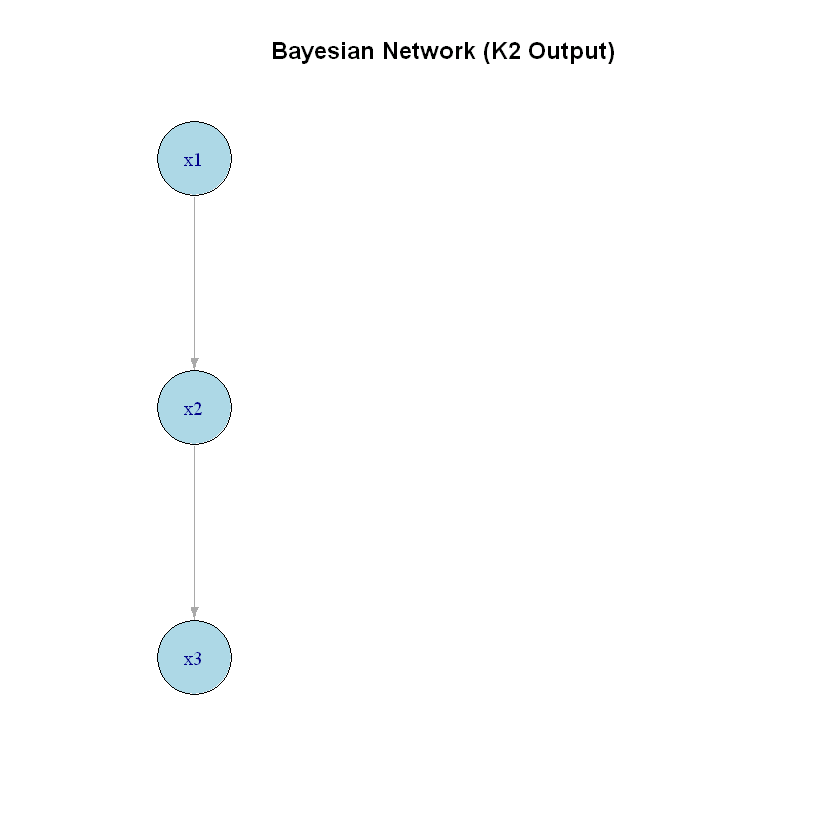

In [25]:
df <- data.frame(x1=c(1,1,0,1,0,0,1,0,1,0), x2=c(0,1,0,1,0,1,1,0,1,0), x3=c(0,1,1,1,0,1,1,0,1,0))

edges <- k2(dataset=df, upperbound=2, nodes.order=colnames(df))

# Convert to graph
g <- graph_from_edgelist(edges, directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     layout = layout_as_tree,
     main = "Bayesian Network")

In [52]:
asia <- read_csv('https://www.ccd.pitt.edu/wiki/images/ASIA10k.csv', show_col_types = FALSE)
colnames(asia)
head(asia)

[1] "asia"   "tub"    "smoke"  "lung"   "bronc"  "either" "xray"   "dysp"

asia,tub,smoke,lung,bronc,either,xray,dysp
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
no,no,no,no,no,no,no,yes
no,no,yes,no,no,no,no,no
no,no,no,no,no,no,no,no
no,no,yes,no,no,no,no,no
no,no,yes,no,yes,no,no,yes
no,no,yes,no,no,no,no,no


In [53]:
edges <- k2(dataset=asia, upperbound=2, nodes.order=colnames(asia))


i:: 1 

predecessors::   pii:: 
piiuz::   
p.old::  NaN 
p.new::  NaN

ERROR: Error in if (p.new > p.old) {: valore mancante dove è richiesto TRUE/FALSE


In [49]:
edges

NULL

In [39]:
# Convert to graph
g <- graph_from_edgelist(edges, directed = TRUE)

# Plot it
plot(g,
     vertex.color = "white",
     vertex.size = 30,
     edge.arrow.size = 0.5,
     layout = layout_as_tree,
     main = "Bayesian Network")

ERROR: Error in graph_from_edgelist(edges, directed = TRUE): graph_from_edgelist expects a matrix with two columns


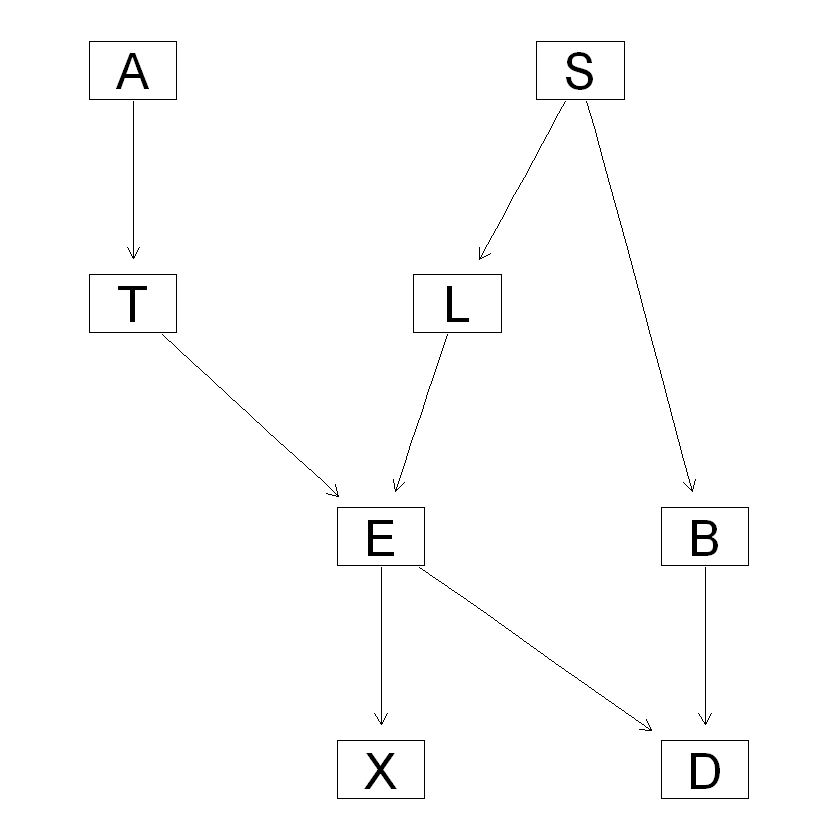

In [36]:
data(asia)
# create and plot the network structure.
dag = model2network("[A][S][T|A][L|S][B|S][D|B:E][E|T:L][X|E]")
graphviz.plot(dag)